<a href="https://colab.research.google.com/github/RangerCoF/SparseConv/blob/main/Caltech101/SparseConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import tarfile
import gzip
import requests
import os

In [2]:
def download_file(url, save_path):
    # Send a request
    response = requests.get(url, stream=True)
    # Check the response status code
    if response.status_code == 200:
        # Open the file in binary write mode
        with open(save_path, 'wb') as f:
            # Write the file chunk by chunk
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)
        print("File downloaded successfully")
    else:
        print("Download failed. Status code:", response.status_code)

def extract_tar(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar file
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

def extract_tar_gz(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar.gz file
    with gzip.open(file_path, 'rb') as gz:
        with tarfile.open(fileobj=gz, mode='r') as tar:
            tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

In [3]:
caltech101_url = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1'
download_path = '/content/downloads'
caltech101_path = download_path + '/caltech-101.zip'

if not os.path.exists(download_path):
  os.makedirs(download_path)

download_file(caltech101_url, caltech101_path)

File downloaded successfully


In [4]:
extract_path = download_path + '/extract'
if not os.path.exists(extract_path):
  os.makedirs(extract_path)
with zipfile.ZipFile(caltech101_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [5]:
dataset_path = '/content/data'
if not os.path.exists(dataset_path):
  os.makedirs(dataset_path)
extract_tar_gz(extract_path + '/caltech-101/101_ObjectCategories.tar.gz', dataset_path)

Extracted '/content/downloads/extract/caltech-101/101_ObjectCategories.tar.gz' to '/content/data'


In [6]:
image_path = dataset_path + '/101_ObjectCategories'

label_list = os.listdir(image_path)
label_list = [item for item in label_list if item!='BACKGROUND_Google']
label_path = [image_path + '/' + item for item in label_list]

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("device=cuda")
else:
    device = torch.device("cpu")
    print("device=cpu")

device=cuda


In [9]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [10]:
images = []
labels = []

for i in range(len(label_path)):
  folder_path = label_path[i]
#for folder_path in label_path:
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    #print(file_path)
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
      img = Image.open(file_path)
      if img.mode != 'RGB':
        img = img.convert('RGB')
      img_transformed = transform(img)
      images.append(img_transformed)
      labels.append(i)

labels = torch.tensor(labels)
train_data, test_data, train_targets, test_targets = train_test_split(images, labels, test_size=0.2, random_state=42)

In [11]:
class SparseConvNetDataset(Dataset):
  def __init__(self, data, targets, device, mask):
    self.data = data
    self.targets = targets
    self.mask = mask
    if type(mask) != int:
        for i in range(len(self.data)):
            self.data[i] = self.data[i] * mask[i]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = torch.cat((self.data[idx], self.mask[idx].unsqueeze(0)), dim=0)
    data = data.to(device)
    targets = self.targets[idx].to(device)
    return data, targets

In [12]:
class SparseConvBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size,
      stride=1,
      padding='same',
      dilation=1):
    super(SparseConvBlock, self).__init__()

    self.conv = nn.Conv2d(
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding,
      dilation=dilation,
      bias=False)

    self.bias = nn.Parameter(
      torch.zeros(out_channels),
      requires_grad=True)

    self.sparsity = nn.Conv2d(
      in_channels=1,
      out_channels=1,
      kernel_size=kernel_size,
      padding=padding,
      dilation=dilation,
      bias=False)
    kernel = torch.FloatTensor(torch.ones([kernel_size, kernel_size])).unsqueeze(0).unsqueeze(0)
    self.sparsity.weight = nn.Parameter(
      data=kernel,
      requires_grad=False)

    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.MaxPool2d(2, 2)
    self.norm = nn.BatchNorm2d(out_channels)

  def forward(self, x, mask):
    x = self.conv(x * mask)
    normalizer = self.sparsity(mask) + 1e-8
    x = x / normalizer + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    x = self.relu(x)
    x = self.pool(x)
    x = self.norm(x)
    mask = self.pool(mask)
    return x, mask


In [13]:
class SparseConvNet(nn.Module):
    def __init__(self):
      super(SparseConvNet, self).__init__()
      self.conv1 = SparseConvBlock(3, 6, 7, padding='same')
      self.conv2 = SparseConvBlock(6, 16, 5, padding='same')
      self.conv3 = SparseConvBlock(16, 16, 3, padding='same')
      self.conv4 = SparseConvBlock(16, 16, 3, padding='same')


      self.fc1 = nn.Linear(16 * 14 * 14, 240)
      self.fc2 = nn.Linear(240, 120)
      self.fc3 = nn.Linear(120, 101)

    def forward(self, x):
      mask = x[:, -1:, :, :]
      x = x[:, :-1, :, :]

      x, mask = self.conv1(x, mask)
      x, mask = self.conv2(x, mask)
      x, mask = self.conv3(x, mask)
      x, mask = self.conv4(x, mask)

      x = x.view(-1, 16 * 14 * 14)
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [14]:
def model_test(model, testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

In [15]:
prob = 0.3
batch_size = 64

train_mask = torch.bernoulli(torch.full(torch.Size([len(train_data)]) + train_data[0].shape[1:], 1 - float(prob)))
test_mask = torch.bernoulli(torch.full(torch.Size([len(test_data)]) + test_data[0].shape[1:], 1 - float(prob)))

trainset = SparseConvNetDataset(train_data, train_targets, device, train_mask)
testset = SparseConvNetDataset(test_data, test_targets, device, test_mask)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

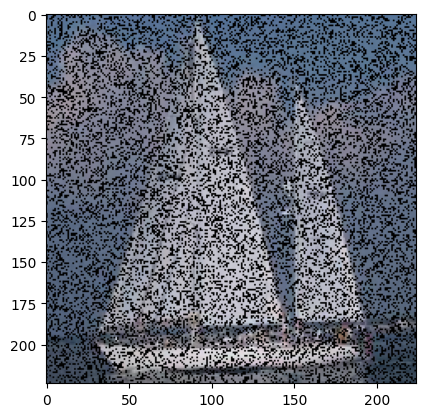

In [16]:
plt.imshow(testset[0][0][:3].cpu().permute(1, 2, 0))

In [17]:
net = SparseConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
acc_sparseconv = []

for epoch in tqdm(range(50)):
    if epoch==25:
          optimizer = optim.Adam(net.parameters(), lr=0.0001)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      inputs, labels = data
      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 20 == 19:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
    acc_sparseconv.append(model_test(net, testloader))
    print('acc: %.3f' % acc_sparseconv[epoch])
print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

[1,    20] loss: 4.03213
[1,    40] loss: 3.36127
[1,    60] loss: 3.18528
[1,    80] loss: 2.91432
[1,   100] loss: 2.68685


  2%|▏         | 1/50 [00:08<07:11,  8.81s/it]

acc: 0.413
[2,    20] loss: 2.14716
[2,    40] loss: 2.01696
[2,    60] loss: 2.03884
[2,    80] loss: 2.00262
[2,   100] loss: 1.88443


  4%|▍         | 2/50 [00:15<06:08,  7.67s/it]

acc: 0.463
[3,    20] loss: 1.22254
[3,    40] loss: 1.13626
[3,    60] loss: 1.11049
[3,    80] loss: 1.14978
[3,   100] loss: 1.16227


  6%|▌         | 3/50 [00:22<05:41,  7.27s/it]

acc: 0.555
[4,    20] loss: 0.57150
[4,    40] loss: 0.45170
[4,    60] loss: 0.49485
[4,    80] loss: 0.47116
[4,   100] loss: 0.51501


  8%|▊         | 4/50 [00:29<05:26,  7.10s/it]

acc: 0.528
[5,    20] loss: 0.21564
[5,    40] loss: 0.13018
[5,    60] loss: 0.13406
[5,    80] loss: 0.13583
[5,   100] loss: 0.15137


 10%|█         | 5/50 [00:36<05:14,  6.99s/it]

acc: 0.588
[6,    20] loss: 0.04714
[6,    40] loss: 0.04580
[6,    60] loss: 0.03355
[6,    80] loss: 0.02885
[6,   100] loss: 0.02714


 12%|█▏        | 6/50 [00:42<05:05,  6.95s/it]

acc: 0.615
[7,    20] loss: 0.01105
[7,    40] loss: 0.00956
[7,    60] loss: 0.00986
[7,    80] loss: 0.00890
[7,   100] loss: 0.00808


 14%|█▍        | 7/50 [00:49<04:57,  6.91s/it]

acc: 0.606
[8,    20] loss: 0.00441
[8,    40] loss: 0.00419
[8,    60] loss: 0.00579
[8,    80] loss: 0.00347
[8,   100] loss: 0.00324


 16%|█▌        | 8/50 [00:56<04:48,  6.87s/it]

acc: 0.620
[9,    20] loss: 0.00252
[9,    40] loss: 0.00239
[9,    60] loss: 0.00222
[9,    80] loss: 0.00260
[9,   100] loss: 0.00219


 18%|█▊        | 9/50 [01:03<04:40,  6.85s/it]

acc: 0.618
[10,    20] loss: 0.00196
[10,    40] loss: 0.00205
[10,    60] loss: 0.00177
[10,    80] loss: 0.00179
[10,   100] loss: 0.00170


 20%|██        | 10/50 [01:10<04:32,  6.82s/it]

acc: 0.620
[11,    20] loss: 0.00147
[11,    40] loss: 0.00147
[11,    60] loss: 0.00154
[11,    80] loss: 0.00148
[11,   100] loss: 0.00140


 22%|██▏       | 11/50 [01:16<04:25,  6.81s/it]

acc: 0.616
[12,    20] loss: 0.00126
[12,    40] loss: 0.00129
[12,    60] loss: 0.00114
[12,    80] loss: 0.00122
[12,   100] loss: 0.00120


 24%|██▍       | 12/50 [01:23<04:18,  6.80s/it]

acc: 0.622
[13,    20] loss: 0.00106
[13,    40] loss: 0.00106
[13,    60] loss: 0.00098
[13,    80] loss: 0.00103
[13,   100] loss: 0.00100


 26%|██▌       | 13/50 [01:30<04:13,  6.86s/it]

acc: 0.618
[14,    20] loss: 0.00092
[14,    40] loss: 0.00086
[14,    60] loss: 0.00094
[14,    80] loss: 0.00089
[14,   100] loss: 0.00086


 28%|██▊       | 14/50 [01:37<04:06,  6.85s/it]

acc: 0.621
[15,    20] loss: 0.00072
[15,    40] loss: 0.00081
[15,    60] loss: 0.00074
[15,    80] loss: 0.00083
[15,   100] loss: 0.00074


 30%|███       | 15/50 [01:44<03:59,  6.85s/it]

acc: 0.618
[16,    20] loss: 0.00067
[16,    40] loss: 0.00070
[16,    60] loss: 0.00076
[16,    80] loss: 0.00067
[16,   100] loss: 0.00072


 32%|███▏      | 16/50 [01:51<03:52,  6.85s/it]

acc: 0.618
[17,    20] loss: 0.00060
[17,    40] loss: 0.00063
[17,    60] loss: 0.00060
[17,    80] loss: 0.00062
[17,   100] loss: 0.00062


 34%|███▍      | 17/50 [01:58<03:45,  6.83s/it]

acc: 0.618
[18,    20] loss: 0.00054
[18,    40] loss: 0.00055
[18,    60] loss: 0.00057
[18,    80] loss: 0.00057
[18,   100] loss: 0.00053


 36%|███▌      | 18/50 [02:04<03:38,  6.82s/it]

acc: 0.618
[19,    20] loss: 0.00048
[19,    40] loss: 0.00048
[19,    60] loss: 0.00045
[19,    80] loss: 0.00050
[19,   100] loss: 0.00050


 38%|███▊      | 19/50 [02:11<03:31,  6.84s/it]

acc: 0.615
[20,    20] loss: 0.00044
[20,    40] loss: 0.00043
[20,    60] loss: 0.00041
[20,    80] loss: 0.00044
[20,   100] loss: 0.00042


 40%|████      | 20/50 [02:18<03:24,  6.82s/it]

acc: 0.619
[21,    20] loss: 0.00038
[21,    40] loss: 0.00039
[21,    60] loss: 0.00037
[21,    80] loss: 0.00038
[21,   100] loss: 0.00043


 42%|████▏     | 21/50 [02:25<03:18,  6.83s/it]

acc: 0.623
[22,    20] loss: 0.00036
[22,    40] loss: 0.00035
[22,    60] loss: 0.00034
[22,    80] loss: 0.00035
[22,   100] loss: 0.00035


 44%|████▍     | 22/50 [02:32<03:11,  6.84s/it]

acc: 0.619
[23,    20] loss: 0.00030
[23,    40] loss: 0.00031
[23,    60] loss: 0.00031
[23,    80] loss: 0.00034
[23,   100] loss: 0.00035


 46%|████▌     | 23/50 [02:39<03:04,  6.84s/it]

acc: 0.621
[24,    20] loss: 0.00028
[24,    40] loss: 0.00029
[24,    60] loss: 0.00030
[24,    80] loss: 0.00029
[24,   100] loss: 0.00029


 48%|████▊     | 24/50 [02:45<02:57,  6.84s/it]

acc: 0.620
[25,    20] loss: 0.00027
[25,    40] loss: 0.00026
[25,    60] loss: 0.00028
[25,    80] loss: 0.00026
[25,   100] loss: 0.00029


 50%|█████     | 25/50 [02:52<02:50,  6.83s/it]

acc: 0.621
[26,    20] loss: 0.00027
[26,    40] loss: 0.00031
[26,    60] loss: 0.00030
[26,    80] loss: 0.00033
[26,   100] loss: 0.00027


 52%|█████▏    | 26/50 [02:59<02:44,  6.84s/it]

acc: 0.618
[27,    20] loss: 0.00016
[27,    40] loss: 0.00015
[27,    60] loss: 0.00013
[27,    80] loss: 0.00015
[27,   100] loss: 0.00021


 54%|█████▍    | 27/50 [03:06<02:37,  6.84s/it]

acc: 0.616
[28,    20] loss: 0.00011
[28,    40] loss: 0.00009
[28,    60] loss: 0.00011
[28,    80] loss: 0.00010
[28,   100] loss: 0.00009


 56%|█████▌    | 28/50 [03:13<02:30,  6.82s/it]

acc: 0.622
[29,    20] loss: 0.00006
[29,    40] loss: 0.00006
[29,    60] loss: 0.00007
[29,    80] loss: 0.00006
[29,   100] loss: 0.00006


 58%|█████▊    | 29/50 [03:19<02:23,  6.82s/it]

acc: 0.622
[30,    20] loss: 0.00004
[30,    40] loss: 0.00006
[30,    60] loss: 0.00006
[30,    80] loss: 0.00005
[30,   100] loss: 0.00005


 60%|██████    | 30/50 [03:26<02:16,  6.83s/it]

acc: 0.628
[31,    20] loss: 0.00004
[31,    40] loss: 0.00004
[31,    60] loss: 0.00004
[31,    80] loss: 0.00004
[31,   100] loss: 0.00004


 62%|██████▏   | 31/50 [03:33<02:09,  6.83s/it]

acc: 0.627
[32,    20] loss: 0.00003
[32,    40] loss: 0.00003
[32,    60] loss: 0.00003
[32,    80] loss: 0.00003
[32,   100] loss: 0.00003


 64%|██████▍   | 32/50 [03:40<02:02,  6.83s/it]

acc: 0.625
[33,    20] loss: 0.00003
[33,    40] loss: 0.00002
[33,    60] loss: 0.00003
[33,    80] loss: 0.00003
[33,   100] loss: 0.00002


 66%|██████▌   | 33/50 [03:47<01:55,  6.78s/it]

acc: 0.627
[34,    20] loss: 0.00002
[34,    40] loss: 0.00002
[34,    60] loss: 0.00002
[34,    80] loss: 0.00002
[34,   100] loss: 0.00002


 68%|██████▊   | 34/50 [03:54<01:49,  6.82s/it]

acc: 0.624
[35,    20] loss: 0.00002
[35,    40] loss: 0.00002
[35,    60] loss: 0.00002
[35,    80] loss: 0.00002
[35,   100] loss: 0.00002


 70%|███████   | 35/50 [04:00<01:42,  6.83s/it]

acc: 0.631
[36,    20] loss: 0.00001
[36,    40] loss: 0.00002
[36,    60] loss: 0.00001
[36,    80] loss: 0.00002
[36,   100] loss: 0.00001


 72%|███████▏  | 36/50 [04:07<01:35,  6.83s/it]

acc: 0.629
[37,    20] loss: 0.00001
[37,    40] loss: 0.00002
[37,    60] loss: 0.00001
[37,    80] loss: 0.00001
[37,   100] loss: 0.00001


 74%|███████▍  | 37/50 [04:14<01:28,  6.83s/it]

acc: 0.628
[38,    20] loss: 0.00001
[38,    40] loss: 0.00001
[38,    60] loss: 0.00001
[38,    80] loss: 0.00001
[38,   100] loss: 0.00001


 76%|███████▌  | 38/50 [04:21<01:21,  6.83s/it]

acc: 0.628
[39,    20] loss: 0.00001
[39,    40] loss: 0.00001
[39,    60] loss: 0.00001
[39,    80] loss: 0.00001
[39,   100] loss: 0.00001


 78%|███████▊  | 39/50 [04:28<01:15,  6.85s/it]

acc: 0.630
[40,    20] loss: 0.00001
[40,    40] loss: 0.00001
[40,    60] loss: 0.00001
[40,    80] loss: 0.00001
[40,   100] loss: 0.00001


 80%|████████  | 40/50 [04:35<01:08,  6.84s/it]

acc: 0.631
[41,    20] loss: 0.00001
[41,    40] loss: 0.00001
[41,    60] loss: 0.00001
[41,    80] loss: 0.00001
[41,   100] loss: 0.00001


 82%|████████▏ | 41/50 [04:41<01:01,  6.82s/it]

acc: 0.632
[42,    20] loss: 0.00001
[42,    40] loss: 0.00001
[42,    60] loss: 0.00001
[42,    80] loss: 0.00001
[42,   100] loss: 0.00001


 84%|████████▍ | 42/50 [04:48<00:54,  6.81s/it]

acc: 0.631
[43,    20] loss: 0.00001
[43,    40] loss: 0.00001
[43,    60] loss: 0.00001
[43,    80] loss: 0.00001
[43,   100] loss: 0.00001


 86%|████████▌ | 43/50 [04:55<00:47,  6.81s/it]

acc: 0.632
[44,    20] loss: 0.00001
[44,    40] loss: 0.00001
[44,    60] loss: 0.00001
[44,    80] loss: 0.00001
[44,   100] loss: 0.00001


 88%|████████▊ | 44/50 [05:02<00:40,  6.81s/it]

acc: 0.631
[45,    20] loss: 0.00001
[45,    40] loss: 0.00001
[45,    60] loss: 0.00000
[45,    80] loss: 0.00001
[45,   100] loss: 0.00001


 90%|█████████ | 45/50 [05:09<00:34,  6.82s/it]

acc: 0.630
[46,    20] loss: 0.00000
[46,    40] loss: 0.00001
[46,    60] loss: 0.00000
[46,    80] loss: 0.00000
[46,   100] loss: 0.00001


 92%|█████████▏| 46/50 [05:15<00:27,  6.82s/it]

acc: 0.630
[47,    20] loss: 0.00000
[47,    40] loss: 0.00000
[47,    60] loss: 0.00001
[47,    80] loss: 0.00000
[47,   100] loss: 0.00000


 94%|█████████▍| 47/50 [05:22<00:20,  6.83s/it]

acc: 0.632
[48,    20] loss: 0.00000
[48,    40] loss: 0.00000
[48,    60] loss: 0.00000
[48,    80] loss: 0.00000
[48,   100] loss: 0.00000


 96%|█████████▌| 48/50 [05:29<00:13,  6.77s/it]

acc: 0.630
[49,    20] loss: 0.00000
[49,    40] loss: 0.00000
[49,    60] loss: 0.00000
[49,    80] loss: 0.00000
[49,   100] loss: 0.00000


 98%|█████████▊| 49/50 [05:36<00:06,  6.78s/it]

acc: 0.631
[50,    20] loss: 0.00000
[50,    40] loss: 0.00000
[50,    60] loss: 0.00000
[50,    80] loss: 0.00000
[50,   100] loss: 0.00000


100%|██████████| 50/50 [05:43<00:00,  6.86s/it]

acc: 0.630
Finished Training


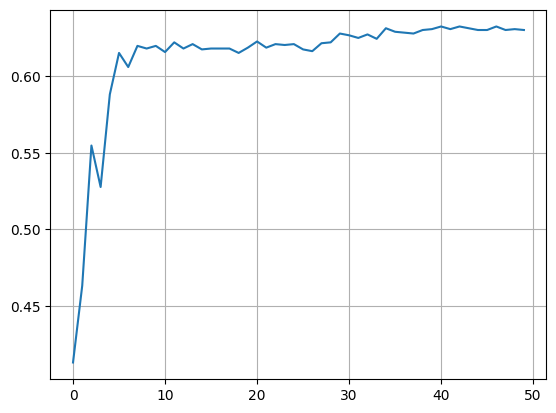

In [18]:
plt.plot(acc_sparseconv)
plt.grid()

  0%|          | 0/20 [00:00<?, ?it/s]

loss: 3.14700
[Sparsity: 0.00, Epoch: 1]acc: 0.404
loss: 1.95317
[Sparsity: 0.00, Epoch: 2]acc: 0.458
loss: 1.14659
[Sparsity: 0.00, Epoch: 3]acc: 0.533
loss: 0.55930
[Sparsity: 0.00, Epoch: 4]acc: 0.595
loss: 0.18213
[Sparsity: 0.00, Epoch: 5]acc: 0.595
loss: 0.03414
[Sparsity: 0.00, Epoch: 6]acc: 0.615
loss: 0.01535
[Sparsity: 0.00, Epoch: 7]acc: 0.626
loss: 0.01007
[Sparsity: 0.00, Epoch: 8]acc: 0.623
loss: 0.00718
[Sparsity: 0.00, Epoch: 9]acc: 0.622
loss: 0.00551
[Sparsity: 0.00, Epoch: 10]acc: 0.626
Finished Training


  5%|▌         | 1/20 [01:24<26:40, 84.22s/it]

[Sparsity: 0.00]acc: 0.626
loss: 3.17577
[Sparsity: 0.05, Epoch: 1]acc: 0.431
loss: 2.07784
[Sparsity: 0.05, Epoch: 2]acc: 0.509
loss: 1.30056
[Sparsity: 0.05, Epoch: 3]acc: 0.532
loss: 0.66424
[Sparsity: 0.05, Epoch: 4]acc: 0.547
loss: 0.25066
[Sparsity: 0.05, Epoch: 5]acc: 0.572
loss: 0.05054
[Sparsity: 0.05, Epoch: 6]acc: 0.606
loss: 0.02284
[Sparsity: 0.05, Epoch: 7]acc: 0.603
loss: 0.01483
[Sparsity: 0.05, Epoch: 8]acc: 0.612
loss: 0.01057
[Sparsity: 0.05, Epoch: 9]acc: 0.613
loss: 0.00806
[Sparsity: 0.05, Epoch: 10]acc: 0.613
Finished Training


 10%|█         | 2/20 [02:48<25:20, 84.46s/it]

[Sparsity: 0.05]acc: 0.613
loss: 3.17859
[Sparsity: 0.10, Epoch: 1]acc: 0.425
loss: 2.05207
[Sparsity: 0.10, Epoch: 2]acc: 0.438
loss: 1.28820
[Sparsity: 0.10, Epoch: 3]acc: 0.528
loss: 0.66446
[Sparsity: 0.10, Epoch: 4]acc: 0.571
loss: 0.24435
[Sparsity: 0.10, Epoch: 5]acc: 0.537
loss: 0.05446
[Sparsity: 0.10, Epoch: 6]acc: 0.603
loss: 0.02387
[Sparsity: 0.10, Epoch: 7]acc: 0.605
loss: 0.01563
[Sparsity: 0.10, Epoch: 8]acc: 0.601
loss: 0.01134
[Sparsity: 0.10, Epoch: 9]acc: 0.606
loss: 0.00867
[Sparsity: 0.10, Epoch: 10]acc: 0.607
Finished Training


 15%|█▌        | 3/20 [04:13<23:56, 84.51s/it]

[Sparsity: 0.10]acc: 0.607
loss: 3.21323
[Sparsity: 0.15, Epoch: 1]acc: 0.389
loss: 2.11117
[Sparsity: 0.15, Epoch: 2]acc: 0.493
loss: 1.33634
[Sparsity: 0.15, Epoch: 3]acc: 0.527
loss: 0.69940
[Sparsity: 0.15, Epoch: 4]acc: 0.536
loss: 0.23429
[Sparsity: 0.15, Epoch: 5]acc: 0.537
loss: 0.04377
[Sparsity: 0.15, Epoch: 6]acc: 0.586
loss: 0.01921
[Sparsity: 0.15, Epoch: 7]acc: 0.584
loss: 0.01273
[Sparsity: 0.15, Epoch: 8]acc: 0.581
loss: 0.00926
[Sparsity: 0.15, Epoch: 9]acc: 0.582
loss: 0.00696
[Sparsity: 0.15, Epoch: 10]acc: 0.586
Finished Training


 20%|██        | 4/20 [05:28<21:32, 80.76s/it]

[Sparsity: 0.15]acc: 0.586
loss: 3.18415
[Sparsity: 0.20, Epoch: 1]acc: 0.410
loss: 2.13062
[Sparsity: 0.20, Epoch: 2]acc: 0.454
loss: 1.38944
[Sparsity: 0.20, Epoch: 3]acc: 0.528
loss: 0.74621
[Sparsity: 0.20, Epoch: 4]acc: 0.541
loss: 0.30051
[Sparsity: 0.20, Epoch: 5]acc: 0.552
loss: 0.05898
[Sparsity: 0.20, Epoch: 6]acc: 0.578
loss: 0.02884
[Sparsity: 0.20, Epoch: 7]acc: 0.583
loss: 0.01788
[Sparsity: 0.20, Epoch: 8]acc: 0.580
loss: 0.01265
[Sparsity: 0.20, Epoch: 9]acc: 0.581
loss: 0.00960
[Sparsity: 0.20, Epoch: 10]acc: 0.582
Finished Training


 25%|██▌       | 5/20 [06:53<20:35, 82.36s/it]

[Sparsity: 0.20]acc: 0.582
loss: 3.27727
[Sparsity: 0.25, Epoch: 1]acc: 0.366
loss: 2.26954
[Sparsity: 0.25, Epoch: 2]acc: 0.461
loss: 1.51154
[Sparsity: 0.25, Epoch: 3]acc: 0.520
loss: 0.79735
[Sparsity: 0.25, Epoch: 4]acc: 0.529
loss: 0.29162
[Sparsity: 0.25, Epoch: 5]acc: 0.488
loss: 0.05356
[Sparsity: 0.25, Epoch: 6]acc: 0.558
loss: 0.02417
[Sparsity: 0.25, Epoch: 7]acc: 0.559
loss: 0.01581
[Sparsity: 0.25, Epoch: 8]acc: 0.563
loss: 0.01082
[Sparsity: 0.25, Epoch: 9]acc: 0.562
loss: 0.00828
[Sparsity: 0.25, Epoch: 10]acc: 0.567
Finished Training


 30%|███       | 6/20 [08:21<19:37, 84.09s/it]

[Sparsity: 0.25]acc: 0.567
loss: 3.29168
[Sparsity: 0.30, Epoch: 1]acc: 0.281
loss: 2.25036
[Sparsity: 0.30, Epoch: 2]acc: 0.474
loss: 1.51971
[Sparsity: 0.30, Epoch: 3]acc: 0.493
loss: 0.83534
[Sparsity: 0.30, Epoch: 4]acc: 0.513
loss: 0.31796
[Sparsity: 0.30, Epoch: 5]acc: 0.499
loss: 0.06283
[Sparsity: 0.30, Epoch: 6]acc: 0.535
loss: 0.03049
[Sparsity: 0.30, Epoch: 7]acc: 0.539
loss: 0.01985
[Sparsity: 0.30, Epoch: 8]acc: 0.539
loss: 0.01395
[Sparsity: 0.30, Epoch: 9]acc: 0.540
loss: 0.01005
[Sparsity: 0.30, Epoch: 10]acc: 0.535
Finished Training


 35%|███▌      | 7/20 [09:42<18:02, 83.28s/it]

[Sparsity: 0.30]acc: 0.535
loss: 3.25587
[Sparsity: 0.35, Epoch: 1]acc: 0.365
loss: 2.21231
[Sparsity: 0.35, Epoch: 2]acc: 0.437
loss: 1.42420
[Sparsity: 0.35, Epoch: 3]acc: 0.459
loss: 0.70668
[Sparsity: 0.35, Epoch: 4]acc: 0.501
loss: 0.20256
[Sparsity: 0.35, Epoch: 5]acc: 0.514
loss: 0.03459
[Sparsity: 0.35, Epoch: 6]acc: 0.541
loss: 0.01478
[Sparsity: 0.35, Epoch: 7]acc: 0.538
loss: 0.00967
[Sparsity: 0.35, Epoch: 8]acc: 0.539
loss: 0.00726
[Sparsity: 0.35, Epoch: 9]acc: 0.542
loss: 0.00540
[Sparsity: 0.35, Epoch: 10]acc: 0.542
Finished Training


 40%|████      | 8/20 [11:06<16:40, 83.40s/it]

[Sparsity: 0.35]acc: 0.542
loss: 3.30211
[Sparsity: 0.40, Epoch: 1]acc: 0.334
loss: 2.27835
[Sparsity: 0.40, Epoch: 2]acc: 0.155
loss: 1.53458
[Sparsity: 0.40, Epoch: 3]acc: 0.476
loss: 0.79334
[Sparsity: 0.40, Epoch: 4]acc: 0.137
loss: 0.26596
[Sparsity: 0.40, Epoch: 5]acc: 0.468
loss: 0.04618
[Sparsity: 0.40, Epoch: 6]acc: 0.501
loss: 0.02049
[Sparsity: 0.40, Epoch: 7]acc: 0.504
loss: 0.01317
[Sparsity: 0.40, Epoch: 8]acc: 0.500
loss: 0.00913
[Sparsity: 0.40, Epoch: 9]acc: 0.504
loss: 0.00673
[Sparsity: 0.40, Epoch: 10]acc: 0.505
Finished Training


 45%|████▌     | 9/20 [12:34<15:35, 85.02s/it]

[Sparsity: 0.40]acc: 0.505
loss: 3.42147
[Sparsity: 0.45, Epoch: 1]acc: 0.259
loss: 2.44356
[Sparsity: 0.45, Epoch: 2]acc: 0.384
loss: 1.70702
[Sparsity: 0.45, Epoch: 3]acc: 0.398
loss: 0.91342
[Sparsity: 0.45, Epoch: 4]acc: 0.430
loss: 0.32276
[Sparsity: 0.45, Epoch: 5]acc: 0.395
loss: 0.05595
[Sparsity: 0.45, Epoch: 6]acc: 0.440
loss: 0.02679
[Sparsity: 0.45, Epoch: 7]acc: 0.450
loss: 0.01680
[Sparsity: 0.45, Epoch: 8]acc: 0.452
loss: 0.01172
[Sparsity: 0.45, Epoch: 9]acc: 0.452
loss: 0.00888
[Sparsity: 0.45, Epoch: 10]acc: 0.454
Finished Training


 50%|█████     | 10/20 [13:59<14:08, 84.81s/it]

[Sparsity: 0.45]acc: 0.454
loss: 3.47089
[Sparsity: 0.50, Epoch: 1]acc: 0.272
loss: 2.53865
[Sparsity: 0.50, Epoch: 2]acc: 0.362
loss: 1.82122
[Sparsity: 0.50, Epoch: 3]acc: 0.306
loss: 1.07782
[Sparsity: 0.50, Epoch: 4]acc: 0.286
loss: 0.45634
[Sparsity: 0.50, Epoch: 5]acc: 0.387
loss: 0.11089
[Sparsity: 0.50, Epoch: 6]acc: 0.419
loss: 0.06107
[Sparsity: 0.50, Epoch: 7]acc: 0.391
loss: 0.04130
[Sparsity: 0.50, Epoch: 8]acc: 0.419
loss: 0.02934
[Sparsity: 0.50, Epoch: 9]acc: 0.421
loss: 0.02136
[Sparsity: 0.50, Epoch: 10]acc: 0.421
Finished Training


 55%|█████▌    | 11/20 [15:23<12:41, 84.63s/it]

[Sparsity: 0.50]acc: 0.421
loss: 3.52397
[Sparsity: 0.55, Epoch: 1]acc: 0.259
loss: 2.66338
[Sparsity: 0.55, Epoch: 2]acc: 0.253
loss: 1.91186
[Sparsity: 0.55, Epoch: 3]acc: 0.142
loss: 1.06637
[Sparsity: 0.55, Epoch: 4]acc: 0.271
loss: 0.38790
[Sparsity: 0.55, Epoch: 5]acc: 0.378
loss: 0.08244
[Sparsity: 0.55, Epoch: 6]acc: 0.376
loss: 0.04307
[Sparsity: 0.55, Epoch: 7]acc: 0.120
loss: 0.02751
[Sparsity: 0.55, Epoch: 8]acc: 0.378
loss: 0.01936
[Sparsity: 0.55, Epoch: 9]acc: 0.339
loss: 0.01349
[Sparsity: 0.55, Epoch: 10]acc: 0.392
Finished Training


 60%|██████    | 12/20 [16:43<11:05, 83.16s/it]

[Sparsity: 0.55]acc: 0.392
loss: 3.63660
[Sparsity: 0.60, Epoch: 1]acc: 0.084
loss: 2.84968
[Sparsity: 0.60, Epoch: 2]acc: 0.213
loss: 2.09731
[Sparsity: 0.60, Epoch: 3]acc: 0.172
loss: 1.21400
[Sparsity: 0.60, Epoch: 4]acc: 0.259
loss: 0.50406
[Sparsity: 0.60, Epoch: 5]acc: 0.334
loss: 0.12742
[Sparsity: 0.60, Epoch: 6]acc: 0.195
loss: 0.07356
[Sparsity: 0.60, Epoch: 7]acc: 0.290
loss: 0.05037
[Sparsity: 0.60, Epoch: 8]acc: 0.324
loss: 0.03474
[Sparsity: 0.60, Epoch: 9]acc: 0.338
loss: 0.02455
[Sparsity: 0.60, Epoch: 10]acc: 0.339
Finished Training


 65%|██████▌   | 13/20 [18:07<09:44, 83.50s/it]

[Sparsity: 0.60]acc: 0.339
loss: 3.84837
[Sparsity: 0.65, Epoch: 1]acc: 0.127
loss: 3.16480
[Sparsity: 0.65, Epoch: 2]acc: 0.011
loss: 2.47473
[Sparsity: 0.65, Epoch: 3]acc: 0.128
loss: 1.59866
[Sparsity: 0.65, Epoch: 4]acc: 0.232
loss: 0.77315
[Sparsity: 0.65, Epoch: 5]acc: 0.195
loss: 0.23040
[Sparsity: 0.65, Epoch: 6]acc: 0.173
loss: 0.14590
[Sparsity: 0.65, Epoch: 7]acc: 0.188
loss: 0.10595
[Sparsity: 0.65, Epoch: 8]acc: 0.251
loss: 0.07509
[Sparsity: 0.65, Epoch: 9]acc: 0.193
loss: 0.05483
[Sparsity: 0.65, Epoch: 10]acc: 0.205
Finished Training


 70%|███████   | 14/20 [19:30<08:20, 83.39s/it]

[Sparsity: 0.65]acc: 0.205
loss: 4.10161
[Sparsity: 0.70, Epoch: 1]acc: 0.097
loss: 3.59522
[Sparsity: 0.70, Epoch: 2]acc: 0.093
loss: 2.96375
[Sparsity: 0.70, Epoch: 3]acc: 0.025
loss: 2.01366
[Sparsity: 0.70, Epoch: 4]acc: 0.021
loss: 1.03014
[Sparsity: 0.70, Epoch: 5]acc: 0.123
loss: 0.31638
[Sparsity: 0.70, Epoch: 6]acc: 0.088
loss: 0.21662
[Sparsity: 0.70, Epoch: 7]acc: 0.029
loss: 0.15949
[Sparsity: 0.70, Epoch: 8]acc: 0.100
loss: 0.11772
[Sparsity: 0.70, Epoch: 9]acc: 0.065
loss: 0.08758
[Sparsity: 0.70, Epoch: 10]acc: 0.139
Finished Training


 75%|███████▌  | 15/20 [20:56<07:00, 84.14s/it]

[Sparsity: 0.70]acc: 0.139
loss: 4.27423
[Sparsity: 0.75, Epoch: 1]acc: 0.093
loss: 3.89183
[Sparsity: 0.75, Epoch: 2]acc: 0.127
loss: 3.41089
[Sparsity: 0.75, Epoch: 3]acc: 0.093
loss: 2.63467
[Sparsity: 0.75, Epoch: 4]acc: 0.050
loss: 1.65947
[Sparsity: 0.75, Epoch: 5]acc: 0.060
loss: 0.76563
[Sparsity: 0.75, Epoch: 6]acc: 0.078
loss: 0.59867
[Sparsity: 0.75, Epoch: 7]acc: 0.085
loss: 0.49965
[Sparsity: 0.75, Epoch: 8]acc: 0.070
loss: 0.41893
[Sparsity: 0.75, Epoch: 9]acc: 0.074
loss: 0.35474
[Sparsity: 0.75, Epoch: 10]acc: 0.070
Finished Training


 80%|████████  | 16/20 [22:15<05:30, 82.68s/it]

[Sparsity: 0.75]acc: 0.070
loss: 4.34033
[Sparsity: 0.80, Epoch: 1]acc: 0.093
loss: 4.07742
[Sparsity: 0.80, Epoch: 2]acc: 0.095
loss: 3.80937
[Sparsity: 0.80, Epoch: 3]acc: 0.093
loss: 3.34792
[Sparsity: 0.80, Epoch: 4]acc: 0.095
loss: 2.73127
[Sparsity: 0.80, Epoch: 5]acc: 0.024
loss: 1.87431
[Sparsity: 0.80, Epoch: 6]acc: 0.047
loss: 1.63256
[Sparsity: 0.80, Epoch: 7]acc: 0.059
loss: 1.46011
[Sparsity: 0.80, Epoch: 8]acc: 0.057
loss: 1.30288
[Sparsity: 0.80, Epoch: 9]acc: 0.059
loss: 1.15229
[Sparsity: 0.80, Epoch: 10]acc: 0.031
Finished Training


 85%|████████▌ | 17/20 [23:39<04:08, 82.92s/it]

[Sparsity: 0.80]acc: 0.031
loss: 4.34197
[Sparsity: 0.85, Epoch: 1]acc: 0.094
loss: 4.19595
[Sparsity: 0.85, Epoch: 2]acc: 0.082
loss: 4.06960
[Sparsity: 0.85, Epoch: 3]acc: 0.084
loss: 3.79925
[Sparsity: 0.85, Epoch: 4]acc: 0.082
loss: 3.12519
[Sparsity: 0.85, Epoch: 5]acc: 0.085
loss: 1.62040
[Sparsity: 0.85, Epoch: 6]acc: 0.073
loss: 1.18985
[Sparsity: 0.85, Epoch: 7]acc: 0.043
loss: 0.94254
[Sparsity: 0.85, Epoch: 8]acc: 0.059
loss: 0.74845
[Sparsity: 0.85, Epoch: 9]acc: 0.085
loss: 0.58672
[Sparsity: 0.85, Epoch: 10]acc: 0.053
Finished Training


 90%|█████████ | 18/20 [24:59<02:44, 82.21s/it]

[Sparsity: 0.85]acc: 0.053
loss: 4.33042
[Sparsity: 0.90, Epoch: 1]acc: 0.094
loss: 4.04228
[Sparsity: 0.90, Epoch: 2]acc: 0.094
loss: 3.39757
[Sparsity: 0.90, Epoch: 3]acc: 0.007
loss: 1.62824
[Sparsity: 0.90, Epoch: 4]acc: 0.013
loss: 0.22250
[Sparsity: 0.90, Epoch: 5]acc: 0.035
loss: 0.01953
[Sparsity: 0.90, Epoch: 6]acc: 0.041
loss: 0.00663
[Sparsity: 0.90, Epoch: 7]acc: 0.052
loss: 0.00423
[Sparsity: 0.90, Epoch: 8]acc: 0.033
loss: 0.00297
[Sparsity: 0.90, Epoch: 9]acc: 0.035
loss: 0.00220
[Sparsity: 0.90, Epoch: 10]acc: 0.044
Finished Training


 95%|█████████▌| 19/20 [26:24<01:22, 82.93s/it]

[Sparsity: 0.90]acc: 0.044
loss: 4.35438
[Sparsity: 0.95, Epoch: 1]acc: 0.025
loss: 4.10043
[Sparsity: 0.95, Epoch: 2]acc: 0.094
loss: 3.20952
[Sparsity: 0.95, Epoch: 3]acc: 0.021
loss: 1.35922
[Sparsity: 0.95, Epoch: 4]acc: 0.028
loss: 0.17099
[Sparsity: 0.95, Epoch: 5]acc: 0.045
loss: 0.01267
[Sparsity: 0.95, Epoch: 6]acc: 0.048
loss: 0.00449
[Sparsity: 0.95, Epoch: 7]acc: 0.064
loss: 0.00282
[Sparsity: 0.95, Epoch: 8]acc: 0.050
loss: 0.00197
[Sparsity: 0.95, Epoch: 9]acc: 0.044
loss: 0.00147
[Sparsity: 0.95, Epoch: 10]acc: 0.073
Finished Training


100%|██████████| 20/20 [27:47<00:00, 83.38s/it]

[Sparsity: 0.95]acc: 0.073


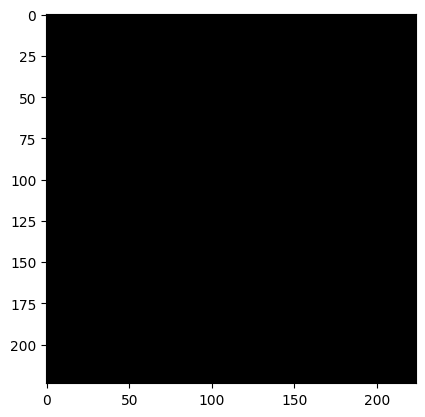

In [19]:
prob_list = np.arange(0, 1, 0.05)
acc_sparseconv = []
batch_size = 64

for prob in tqdm(prob_list):
  train_mask = torch.bernoulli(torch.full(torch.Size([len(train_data)]) + train_data[0].shape[1:], 1 - float(prob)))
  test_mask = torch.bernoulli(torch.full(torch.Size([len(test_data)]) + test_data[0].shape[1:], 1 - float(prob)))


  trainset = SparseConvNetDataset(train_data, train_targets, device, train_mask)
  testset = SparseConvNetDataset(test_data, test_targets, device, test_mask)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
  plt.imshow(testset[0][0][:3].detach().cpu().permute(1, 2, 0))
  plt.show()

  net = SparseConvNet().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  for epoch in range(10):
      if epoch==5:
            optimizer = optim.Adam(net.parameters(), lr=0.0001)
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if i % 20 == 19:
        #       print('[%d, %5d] loss: %.5f' %
        #             (epoch + 1, i + 1, running_loss / 20))
        #       running_loss = 0.0
      print('loss: %.5f' % (running_loss / i))
      running_loss = 0.0
      print('[Sparsity: %.2f, Epoch: %d]acc: %.3f' % (prob, epoch + 1, model_test(net, testloader)))

  print('Finished Training')
  acc_sparseconv.append(model_test(net, testloader))
  print('[Sparsity: %.2f]acc: %.3f' % (prob, acc_sparseconv[-1]))

In [20]:
print(acc_sparseconv)

[0.6261520737327189, 0.613479262672811, 0.6071428571428571, 0.5858294930875576, 0.5817972350230415, 0.5668202764976958, 0.5351382488479263, 0.5420506912442397, 0.5046082949308756, 0.4544930875576037, 0.4210829493087558, 0.391705069124424, 0.3387096774193548, 0.20506912442396313, 0.13882488479262672, 0.06970046082949309, 0.03052995391705069, 0.052995391705069124, 0.04377880184331797, 0.07315668202764977]


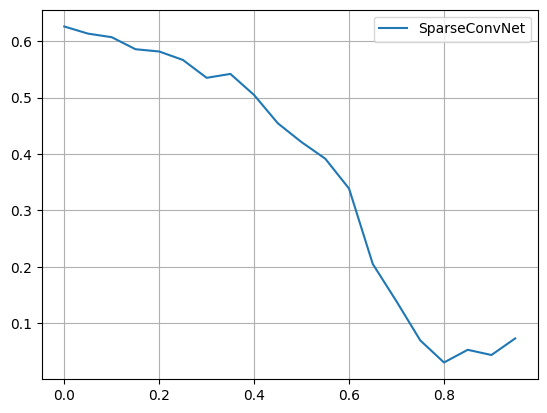

In [21]:
plt.plot(prob_list, acc_sparseconv, label='SparseConvNet')
plt.grid()
plt.legend()